In [1]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.gridspec as gridspec

from utils.plotting import savefig, load_default_mpl_config
from utils.data import load_xval
from utils.shapefiles import get_shapefile

In [2]:
load_default_mpl_config()

PLOT_PATH = Path('/mydata/machflow/basil/mach-flow/analysis/upscaling_vis/')

In [3]:
ds = load_xval(
    xval_dir='/mydata/machflow/basil/runs/basin_level/staticall_allbasins_sqrttrans/LSTM/xval/',
    sources=0).sel(time=slice('1962', '2023'))
prevah = get_shapefile(source='prevah')

In [4]:
def add_data(
        da: xr.DataArray,
        gd: gpd.GeoDataFrame, 
        new_col='da_var',
        allow_missing_id: bool = False) -> gpd.GeoDataFrame:

    da = da.load()

    gd[new_col] = da.sel(station=gd.OID.values).values

    return gd


def digitize(x: xr.DataArray) -> xr.DataArray:
    num_bins = 13
    q = x.sel(time=slice('1971', '2000')).quantile(np.linspace(0.0, 1.0, num_bins), dim='time')
    # q = xr.apply_ufunc(np.digitize, x, q.values, input_core_dims=[('time')], vectorize = True)
    r = xr.apply_ufunc(
        np.digitize, x, q,
        input_core_dims=[['time'], ['quantile']],
        output_core_dims=[['time']], vectorize=True) / num_bins

    return r


In [5]:
qmm_year = ds.Qmm_mod.resample(time='1Y').sum('time').mean('cv').compute()
qmm_year_ref = qmm_year.sel(time=slice('1971', '2000')).mean('time').compute()
qmm_year_ano = (qmm_year - qmm_year_ref).compute()

In [6]:
qmm_year_ano_dig = digitize(qmm_year_ano)

In [7]:
qmm_dec_mean = qmm_year_ano.copy()
year = qmm_dec_mean['time'].dt.year
decade = ((year - 1960) // 10).astype(int)
qmm_dec_mean['decade'] = decade
qmm_dec_mean = qmm_dec_mean.groupby('decade').mean('time')

In [8]:
qmm_dec_ano = (qmm_year_ano * ds.area).sum('station') / ds.area.sum()
qmm_dec_ano = qmm_dec_ano - qmm_dec_ano.sel(time=slice('1971', '2000')).mean('time')
year = qmm_dec_ano['time'].dt.year
decade = ((year - 1960) // 10).astype(int)
qmm_dec_ano['decade'] = decade
qmm_dec_ano = qmm_dec_ano.groupby('decade').mean('time')

plotting year means: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:27<00:00,  2.32it/s]


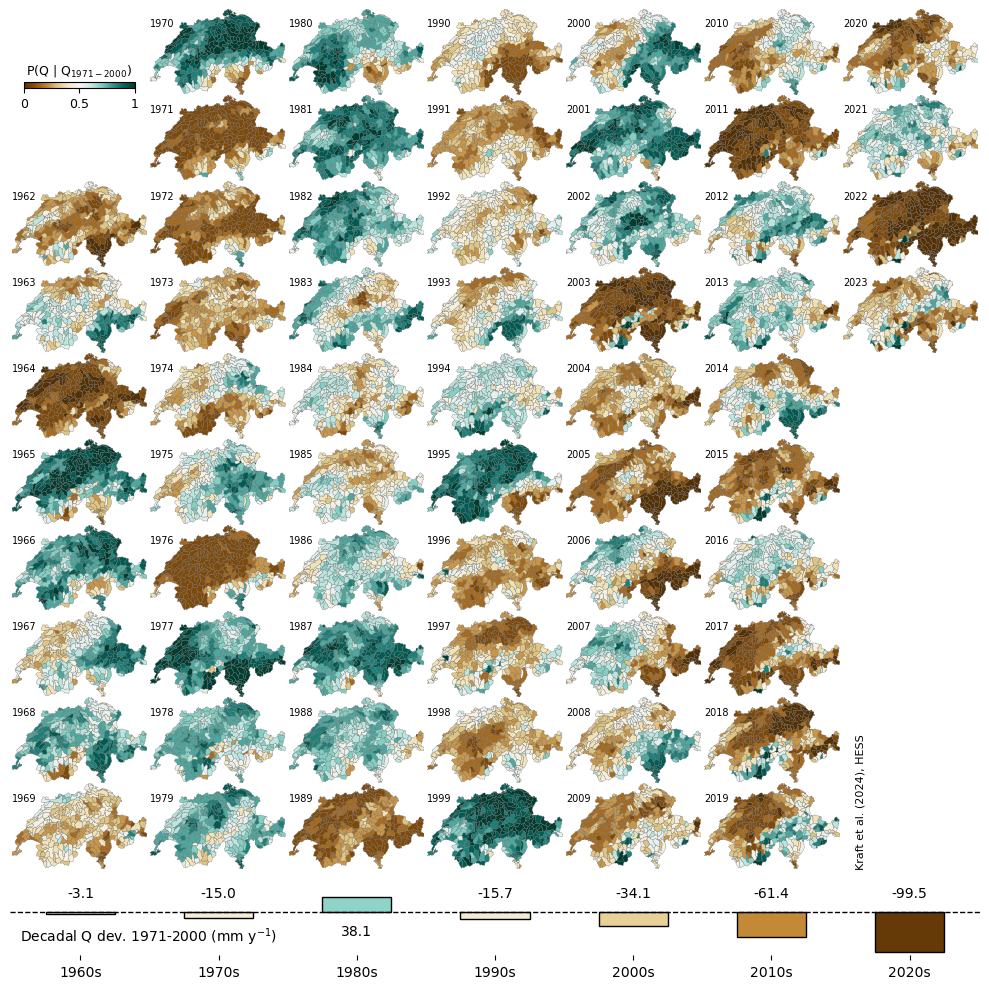

In [24]:

fig = plt.figure(tight_layout=True, figsize=(10, 10))
gs = gridspec.GridSpec(11, 7, wspace=0, hspace=0)

min_year = 1962
max_year = 2023
# max_year = 1972
all_years = range(1960, 2024)

cmap = 'BrBG'

for i, year in tqdm(enumerate(all_years), total=len(all_years), ncols=120, desc='plotting year means'):
    row = year % 10
    col = (year - 1960) // 10

    ax = fig.add_subplot(gs[row, col])

    if (year < min_year) or (year > max_year):
        ax.remove()
        continue

    prevah_mean_qmm = add_data(da=qmm_year_ano_dig.sel(time=str(year)), gd=prevah, new_col='Qmm_sim')

    im = prevah_mean_qmm.plot(
        ax=ax,
        column='Qmm_sim',
        legend=False,
        facecolor='tab:blue',
        edgecolor='0.4',
        cmap=cmap,
        vmin=0,
        vmax=1,
        lw=0.2,
        alpha=1.0,
    )

    ax.axis('off')
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.margins(0)
    ax.set_title(str(year), x=0, y=0.7, ha='left', size=7)

def gradientbars(bars):

    ax = bars[0].axes

    ymin, ymax = ax.get_ylim()
    yabs = max(np.abs(ymin), ymax)

    cm = plt.get_cmap(cmap)

    for i, bar in enumerate(bars):
        bar.set_zorder(1)
        y = bar.get_height()
        y_norm = (y + yabs) / 2 / yabs
        
        bar.set_facecolor(cm(y_norm))
        bar.set_edgecolor('k')
        ax.text(
            i, 30 if y < 0 else -30, f'{y:0.1f}',
            va='bottom' if y < 0 else 'top', ha='center', color='k',
            )

    return -yabs, yabs

cax = fig.add_subplot(gs[0, 0])
patch_col = im.collections[0]
cb = fig.colorbar(patch_col, ax=cax, orientation='horizontal', shrink=0.8)
cax.axis('off')
cb.ax.set_title('P(Q | Q$_{1971-2000}$)', size=9)
cb.ax.set_xticks([0, 0.5, 1])
cb.ax.set_xticklabels(['0', '0.5', '1'])
cb.ax.tick_params(labelsize=9)

ax_dec = fig.add_subplot(gs[-1, :])
bar = ax_dec.bar([f'{d}s' for d in range(1960, 2021, 10)], qmm_dec_ano, width=0.5)
ymin, ymax = gradientbars(bar)
ax_dec.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
ax_dec.set_ylim(ymin, ymax)
ax_dec.axhline(0, color='k', ls='--', lw=1)
ax_dec.text(0.01, 0.1, 'Decadal Q dev. 1971-2000 (mm y$^{-1}$)', va='bottom', ha='left', transform=ax_dec.transAxes)
ax_dec.margins(x=0.04)
ax_dec.set_yticks([])

lax = fig.add_subplot(gs[-2, -1])
lax.axis('off')
lax.text(0.1, 0.0, 'Kraft et al. (2024), HESS', va='bottom', ha='left', transform=lax.transAxes, size=8, rotation=90)

savefig(fig, PLOT_PATH / 'national_trend_grid.png', dpi=450)


plotting year means: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.16it/s]


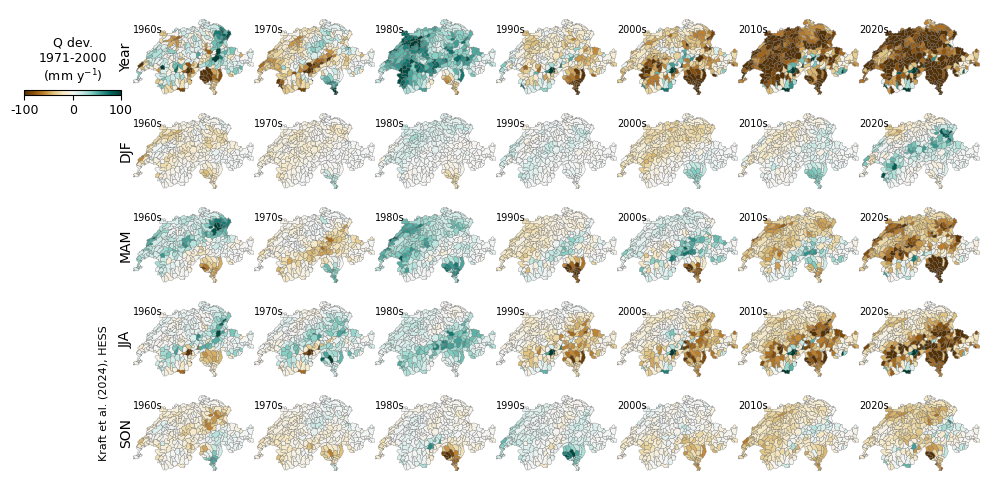

In [27]:
fig = plt.figure(tight_layout=True, figsize=(10, 5))
gs = gridspec.GridSpec(5, 8, wspace=0, hspace=0)

decades = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
cmap = 'BrBG'

for s, season in enumerate([None, 'DJF', 'MAM', 'JJA', 'SON']):
# for s, season in enumerate([['DJF', 'JJA', 'MAM', 'SON']]):
    if season is not None:
        ds_s = ds.sel(time=ds.time.dt.season.isin(season))
    else:
        ds_s = ds

    qmm_year = ds_s.Qmm_mod.resample(time='1Y').sum('time', skipna=False).compute()

    if 'cv' in qmm_year.dims:
        qmm_year = qmm_year.mean('cv')

    qmm_year = qmm_year.compute()

    qmm_year_ref = qmm_year.sel(time=slice('1971', '2000')).mean('time').compute()
    qmm_year_ano = (qmm_year - qmm_year_ref).compute()

    qmm_dec_mean = qmm_year_ano.copy()
    year = qmm_dec_mean['time'].dt.year
    decade = ((year - 1960) // 10).astype(int)
    qmm_dec_mean['decade'] = decade
    qmm_dec_mean = qmm_dec_mean.groupby('decade').mean('time')

    for i, decade in tqdm(enumerate(decades), total=7, ncols=120, desc='plotting year means'):

        ax = fig.add_subplot(gs[s, i + 1])

        data = add_data(da=qmm_dec_mean.isel(decade=i), gd=prevah, new_col='Qmm_sim')

        im = data.plot(
            ax=ax,
            column='Qmm_sim',
            legend=False,
            facecolor='tab:blue',
            edgecolor='0.4',
            cmap=cmap,
            vmin=-100,
            vmax=100,
            lw=0.2,
            alpha=1.0,
        )

        ax.axis('off')
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        ax.margins(0)
        ax.set_title(f'{decade}s', x=0, y=0.7, ha='left', size=7)

        if i == 0:
            if s == 0:
                season_label = 'Year'
            else:
                season_label = season

            ax.text(0, 0.5, season_label, transform=ax.transAxes, ha='right', va='center', rotation=90)

cax = fig.add_subplot(gs[0, 0])
patch_col = im.collections[0]
cb = fig.colorbar(patch_col, ax=cax, orientation='horizontal', shrink=0.8)
cax.axis('off')
cb.ax.set_title('Q dev.\n1971-2000\n(mm y$^{-1}$)', size=9)
cb.ax.set_xticks([-100, 0, 100])
cb.ax.set_xticklabels(['-100', '0', '100'])
cb.ax.tick_params(labelsize=9)

lax = fig.add_subplot(gs[-1, 0])
lax.axis('off')
lax.text(0.8, 0.2, 'Kraft et al. (2024), HESS', va='bottom', ha='right', transform=lax.transAxes, size=8, rotation=90)

savefig(fig, PLOT_PATH / 'national_decadal_trend_grid.png', dpi=450)